# Environment

In [2]:
import re
import torch
import random
import torchaudio
import sam_classifier
from pathlib import Path
import pytorch_lightning as pl
from IPython.display import Audio
from helpers import plot as cora_plot
from helpers.path_utils import get_base_dir

# Seconds to split each recording
# it will be the size of input (secs)
CHUNK_SECS = 3

# The upper bound the recording (input, output or both)
# is going to be filtered with Butterworth Filter (Hz)
CUTOFF_FREQ = 270
# How strict the Lowpass Filter is filtering undesired frequencies
FILTER_ORDER = 4

# Number of Mel frequency bands in the spectrogram
N_MELS = 128
# Window size for Fast Fourier Transform (FFT)
N_FFT = 1024
# Number of samples between successive windows (definition of overlap)
HOP_LENGTH = 512

# Params for training
BATCH_SIZE = 10
TRAIN_RATIO = 0.80
VAL_RATIO = 0.15

main_dir = get_base_dir()
BASE_DIR = main_dir.joinpath("data", "mobile", "SAM")

In [4]:
audios = list(BASE_DIR.glob("*.wav"))
lucky_one = random.choice(audios)
_, sample_rate = torchaudio.load(str(lucky_one))

print(f"Sample rate: {sample_rate}")

Sample rate: 22050


# Instance Dataset

In [5]:
transformations = sam_classifier.Compose(
    [
        sam_classifier.LowpassFilter(
            sample_rate=sample_rate, cutoff_freq=CUTOFF_FREQ, order=FILTER_ORDER
        ),
        sam_classifier.Normalize(),
        sam_classifier.ToMelSpectrogram(
            sample_rate=sample_rate, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
        ),
    ]
)

cora_dataset = sam_classifier.SAM_Dataset(
    BASE_DIR, CHUNK_SECS, transform=transformations
)
n_classes = len(cora_dataset.label_to_idx)
n_samples = len(cora_dataset)

print(f"Number of samples: {n_samples}")
print(f"Number of classes: {n_classes}")

Number of samples: 360
Number of classes: 9


# Get a sample

In [4]:
choosen_one = random.randint(0, n_samples - 1)
print(f"#{choosen_one + 1} / {n_samples}")

mobile_spectrogram, class_label = cora_dataset[choosen_one]

print(f"Class: {class_label}")
print(f"Spectrogram shape: {mobile_spectrogram.shape}")

mobile_sample = mel_spectrogram_to_audio(
    mobile_spectrogram, sample_rate, N_FFT, HOP_LENGTH, N_MELS, num_iters=32
)
print(f"Waveform shape: {mobile_sample.shape}")
display(Audio(mobile_sample, rate=sample_rate, autoplay=True))

#28 / 360
Class: SAM-Fourth Heart Sound
Spectrogram shape: torch.Size([1, 128, 130])


TypeError: DB_to_amplitude() missing 3 required positional arguments: 'x', 'ref', and 'power'

## Without transformations

Clase: SAM-Normal Heart Sounds 90 BPM
Celular sin transformaciones: 


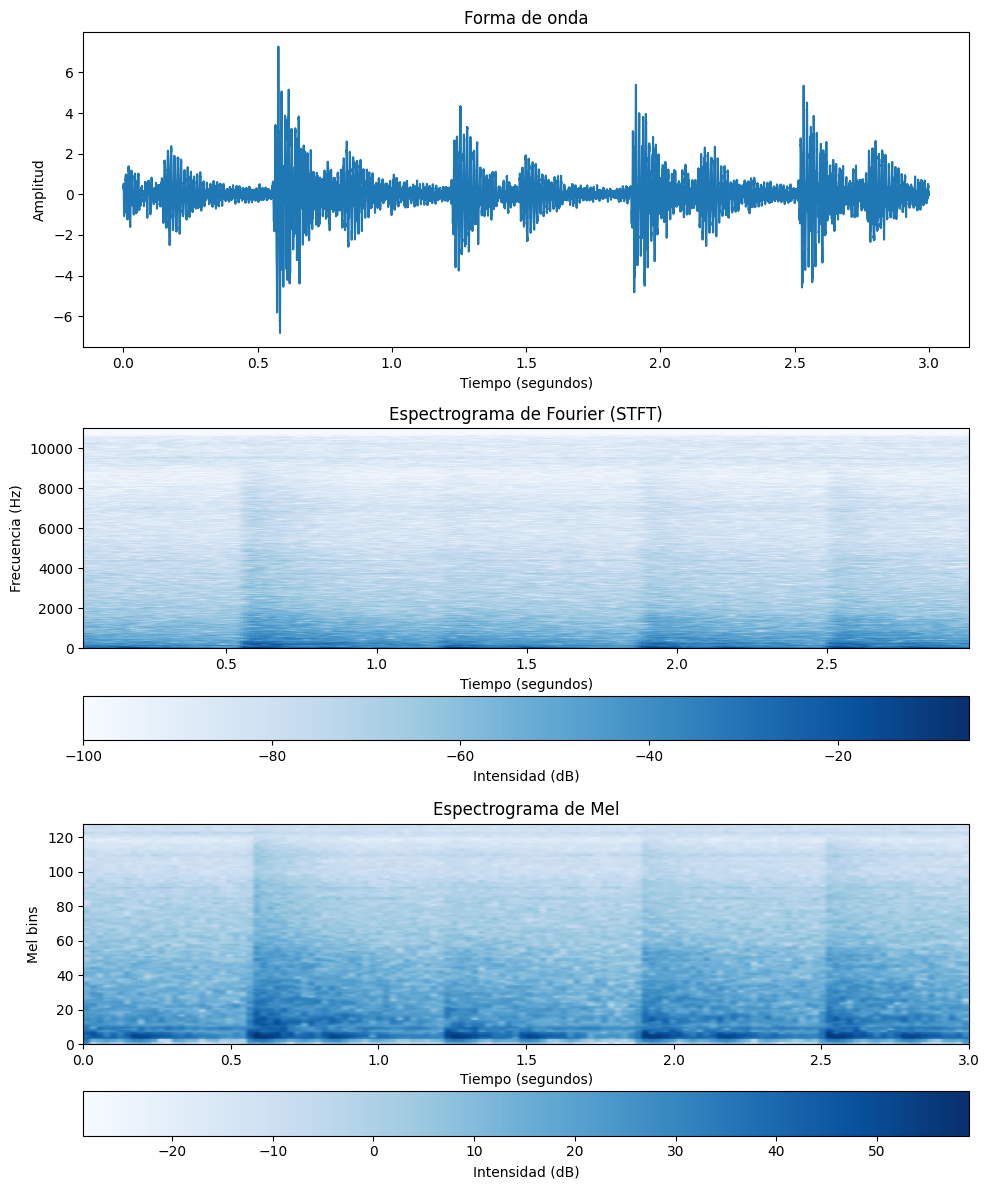

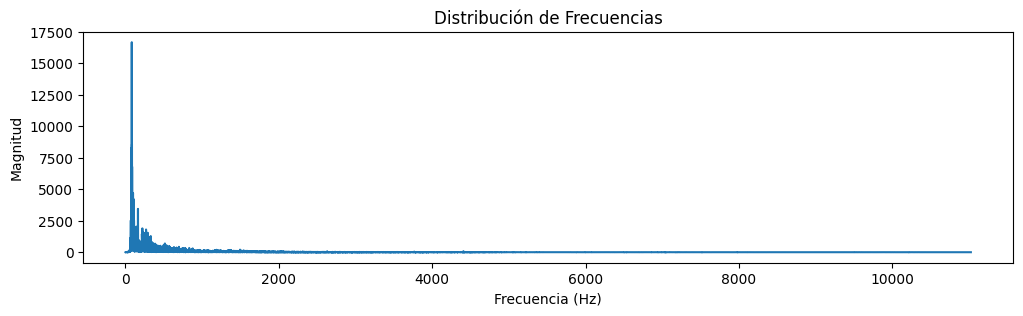

In [6]:
without_transform = sam_classifier.SAM_Dataset(
    BASE_DIR, CHUNK_SECS, transform=sam_classifier.Compose([sam_classifier.Normalize()])
)
mobile_original, _ = without_transform[choosen_one]

print(f"Clase: {class_label}")
print("Celular sin transformaciones: ")
plot_waveform_and_spectrograms(mobile_original, sample_rate)
plot_audio_fft(mobile_original, sample_rate)
Audio(mobile_original, rate=sample_rate, autoplay=True)

In [7]:
from helpers.trigger import save_wave_to_wav

to_export = {
    "SAM-Celular original": mobile_original,
    "SAM-Celular con filtro": mobile_sample,
}
filedir = get_base_dir().joinpath("data", "sam-compare-filters")

for filename, audio in to_export.items():
    save_wave_to_wav(audio.squeeze().numpy(), sample_rate, filedir, filename)

El archivo 'SAM-Celular original.wav' se ha guardado exitosamente en:
C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\coratech\data\sam-compare-filters
El archivo 'SAM-Celular con filtro.wav' se ha guardado exitosamente en:
C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\coratech\data\sam-compare-filters


Compare the original vs the model input

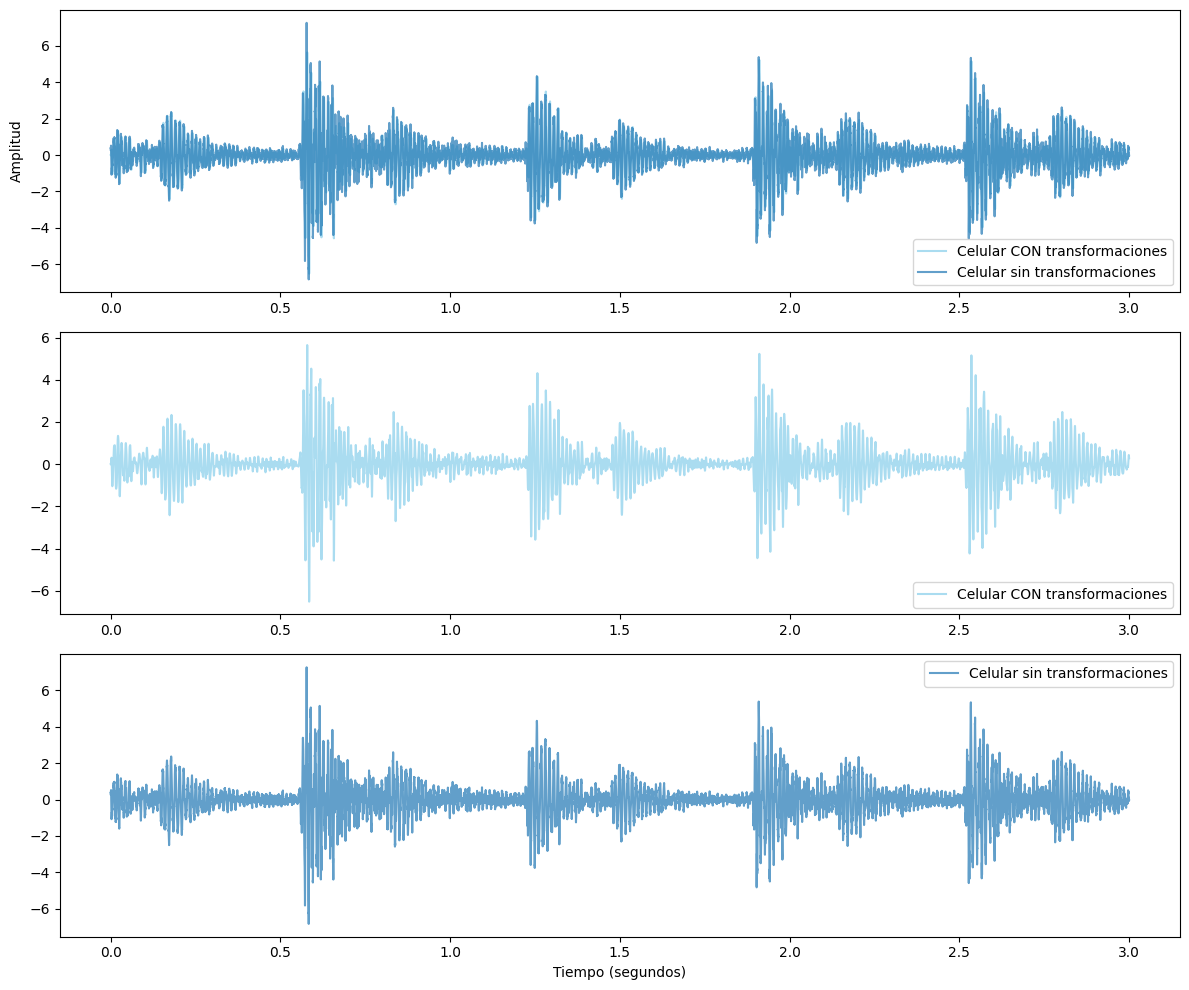

Celular original:


Celular con ruido y Filtro Butterworth:


In [8]:
compare_audios(
    first_audio=mobile_sample,
    first_title="Celular CON transformaciones",
    second_audio=mobile_original,
    second_title="Celular sin transformaciones",
    sample_rate=sample_rate,
)

print("Celular original:")
display(Audio(mobile_original, rate=sample_rate, autoplay=True))
print("Celular con Filtro Butterworth:")
display(Audio(mobile_sample, rate=sample_rate, autoplay=True))

# Train, validation and test split

In [9]:
train_size = int(TRAIN_RATIO * len(cora_dataset))
val_size = int(VAL_RATIO * len(cora_dataset))
test_size = len(cora_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    cora_dataset, [train_size, val_size, test_size]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples:\t\t{train_size} = {len(train_dataloader)} batches")
print(f"Validation samples:\t{val_size} = {len(val_dataloader)} batches")
print(f"Test samples:\t\t{test_size} = {len(test_dataloader)} batches")
print(
    f"Total samples:\t\t{train_size + val_size + test_size} = {len(cora_dataset) // BATCH_SIZE} batches"
)

Batch size: 10
Train samples:		288 = 29 batches
Validation samples:	54 = 6 batches
Test samples:		18 = 2 batches
Total samples:		360 = 36 batches


# Callbacks

In [19]:
input_secs = mobile_sample.shape[-1] // sample_rate

checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath=f"checkpoints/input-{input_secs}s",
    filename="model-{val_loss:.4f}-{epoch:02d}",
    save_top_k=1,
    mode="min",
)

early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

callbacks = [checkpoint, early_stopping, lr_monitor]

# Train!

In [20]:
input_size = cora_dataset[0][0].shape[-1]
trained_model = sam_classifier.CoraTechModelWaveform(input_size)

logger = pl.loggers.tensorboard.TensorBoardLogger("logs/", name="coratech_model")

trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, logger=logger)
trainer.fit(trained_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\coratech\notebooks\model\checkpoints\input-3s exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | fc1     | Linear      | 3.1 M  | train
1 | bn1     | BatchNorm1d | 512    | train
2 | fc2     | Linear      | 32.9 K | train
3 | bn2     | BatchNorm1d | 256    | train
4 | fc3     | Linear      | 33.0 K | train
5 | bn3     | BatchNorm1d | 512    | train
6 | fc4     | Linear      | 3.1 M  | train
7 | relu    | ReLU        | 0      | train
8 | dropout | Dropout     | 0      | train
------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.894    T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Predict

## Best model

In [21]:
directory = Path("checkpoints").joinpath(f"input-{input_secs}s")
pattern = r"model-val_loss=([\d\.]+)-epoch=\d+\.ckpt"
val_loss_values = {}

for model_path in directory.iterdir():
    if model_path.is_file():
        match = re.match(pattern, model_path.name)
        if match:
            val_loss = float(match.group(1))
            val_loss_values[model_path] = val_loss

if val_loss_values:
    best_model = min(val_loss_values, key=val_loss_values.get)
    print(
        f"The {input_secs}s-input model with the lowest validation loss is:\n{best_sam_classifier.name}\nwith a loss of {val_loss_values[best_model]}"
    )
else:
    print("No models matching the specified pattern were found.")

The 3s-input model with the lowest validation loss is:
model-val_loss=0.5756-epoch=02.ckpt
with a loss of 0.5756


In [22]:
model_to_pred = sam_classifier.CoraTechModelWaveform(input_size)

model_to_pred.load_state_dict(torch.load(best_model)["state_dict"])
model_to_pred.eval()

CoraTechModelWaveform(
  (fc1): Linear(in_features=12000, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=12000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

# Loss in validation set

In [23]:
total_loss = 0.0
num_samples = 0

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch
        predictions = model_to_pred(inputs)
        batch_loss = torch.nn.L1Loss()(predictions, targets)
        total_loss += batch_loss.item()
        num_samples += len(inputs)

mse_loss = total_loss / num_samples
print(f"MAE Loss in test set: {mse_loss:.4f}")

MAE Loss in test set: 0.0572


# Result!

#17 / 20


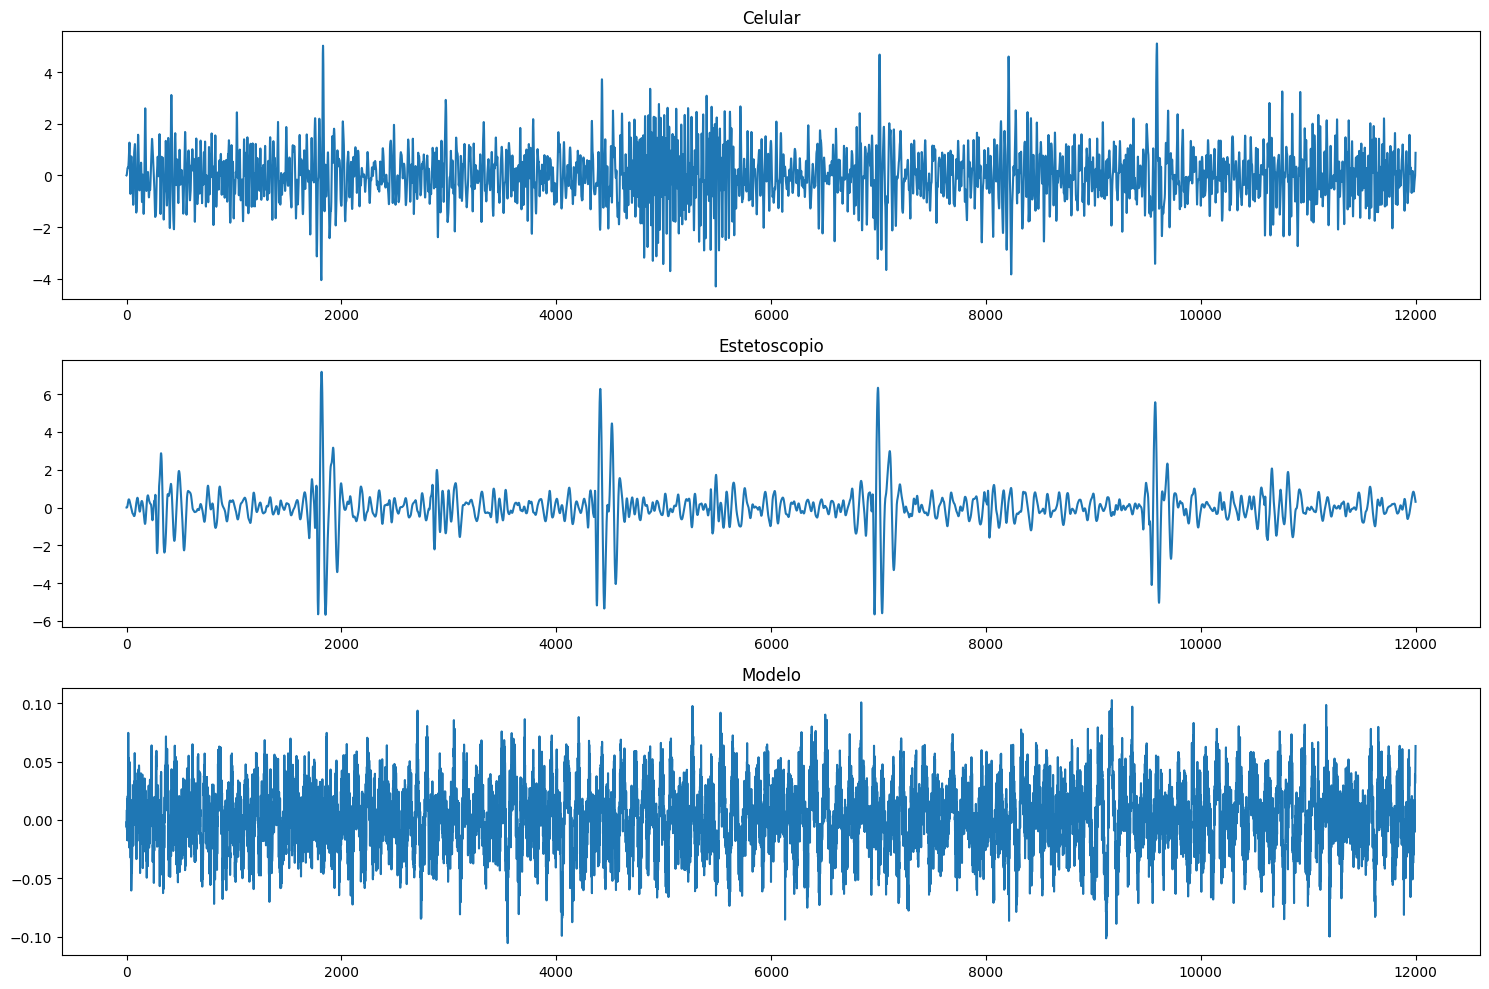

Celular:


Estetoscopio:


Modelo:


In [24]:
test_data_length = len(test_dataset)
choosen_one_test = randint(0, test_data_length - 1)

print(f"#{choosen_one_test + 1} / {test_data_length}")

model_result = plot_model_result(model_to_pred, test_dataset, choosen_one_test)

mobile_test_sample, stethos_test_sample = test_dataset[choosen_one_test]

print("Celular:")
display(Audio(mobile_test_sample, rate=sample_rate, autoplay=True))
print("Estetoscopio:")
display(Audio(stethos_test_sample, rate=sample_rate, autoplay=True))
print("Modelo:")
display(Audio(model_result, rate=sample_rate, autoplay=True))

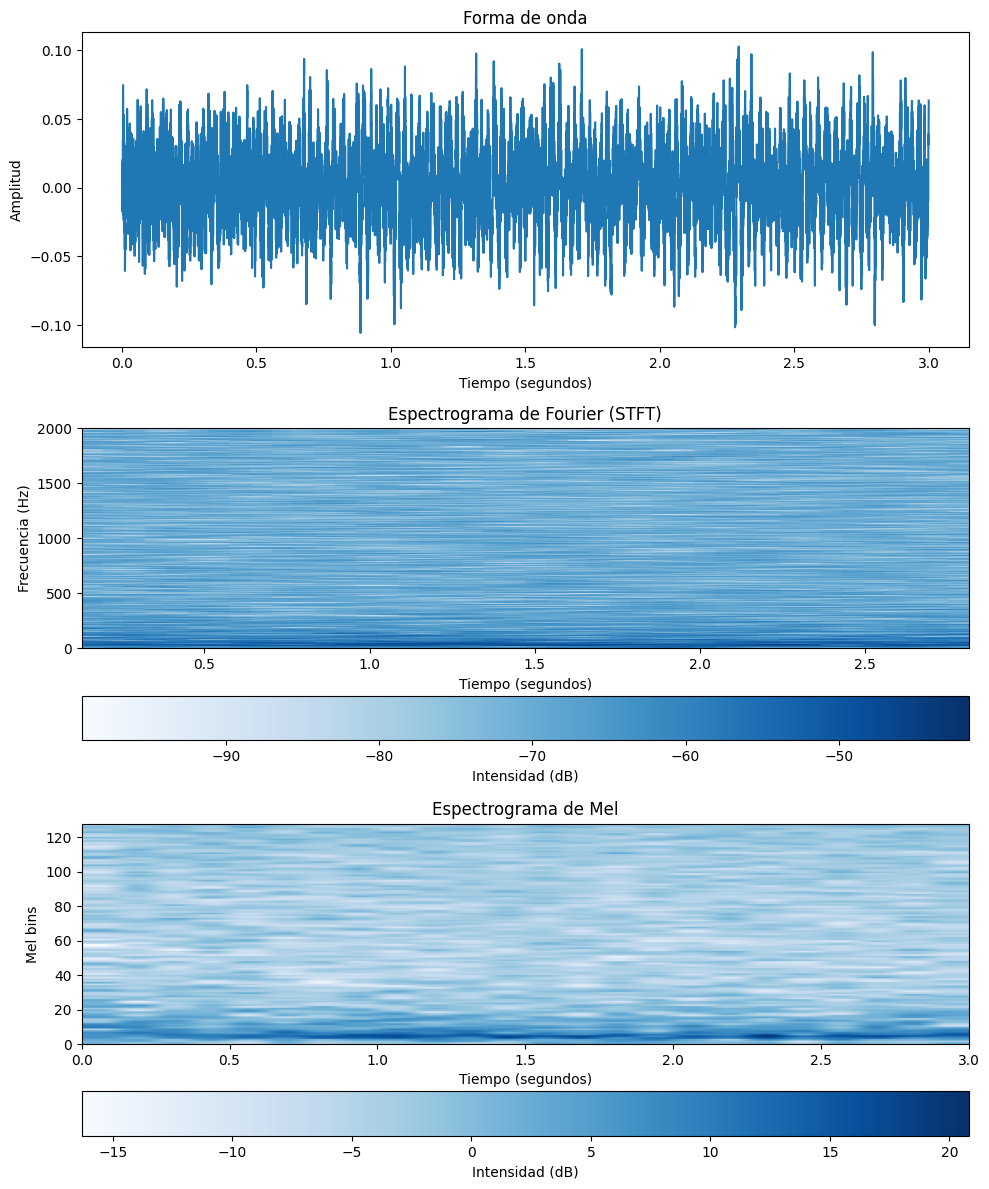

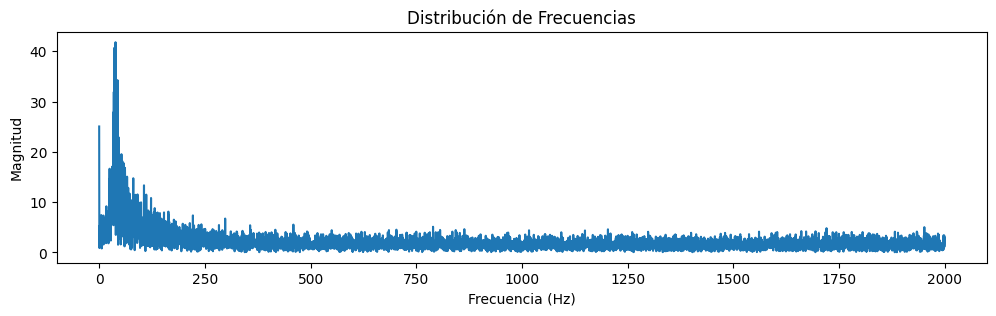

In [25]:
plot_waveform_and_spectrograms(model_result, sample_rate)
plot_audio_fft(model_result, sample_rate)
display(Audio(model_result, rate=sample_rate, autoplay=True))